<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 1: </span>Introduction and EDA</h1>
<hr>
<br>
The following is an illustration of how machine learning and classification models could be applied to build a trade selection algorithm

#### Import Libraries

In [70]:
# Data Manipulation
import numpy as np
import pandas as pd

#Data Visualization
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.available
import seaborn as sns
plt.style.use('ggplot') 

#file processing and misc
from datetime import datetime
from time import strftime
import os
import csv
import sys

#Feature selection/transformation, Machine Learning
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import PowerTransformer, minmax_scale
from sklearn.feature_selection import SelectFromModel

#classification models to be used
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# cross-validaion, hyperparameter tuning, classification performance
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

#### Function to convert from excel integers to dates

In [4]:
def convert_int_to_date(x):
    
    dt = datetime.fromordinal(datetime(1900,1,1).toordinal() + x-2)
    
    return dt

#### Read each file and initial feature engineering

In [10]:
def feat_prep(file):
    
    #Read file
    df = pd.read_csv(file, header=None)
    
    #Name columns
    df.columns = ['Date','Long_Short','Win_Loss','PL','T1','DR','5DR','BPV','AvgRng5','SDRng5','AvgRng100','PV1','PV2','PV3','PV4',
                  'PV5','PV6','PV7','PV8','PV9','PV10','PV11','PV12','PV13','LrD','RSQ','SLP','TotVR','D1','D2','D3','D4','D5',
                  'OHL','NA']
    df = df.drop('NA',axis=1)
    
    #apply convert function to date column
    df['Date'] = df['Date'].apply(convert_int_to_date)
    
    #convert PL into percentage, dividing by 2M results in 0.5% risk per trade
    df['PctRet'] = df['PL'] / 2000000
    
    #initial feature engineering
    df['PctRng5'] = df['DR'] / df['5DR']
    df['PctRng100'] = df['DR'] / df['AvgRng100']
    df['DR_DV'] = df['DR'] * df['BPV']
    df['5DR_DV'] = df['5DR'] * df['BPV']
    df['SDRng5_DV'] = df['SDRng5'] * df['BPV']
    df['AvgRng100_DV'] = df['AvgRng100'] * df['BPV']
    df['VS1'] = df['PV1'] + df['PV2']
    df['VS2'] = df['PV3'] + df['PV4'] + df['PV5']
    df['VS3'] = df['PV6'] + df['PV7'] + df['PV8']
    df['VS4'] = df['PV9'] + df['PV10'] + df['PV11']
    df['VS5'] = df['PV12'] + df['PV13']
    df['VR1'] = df['VS1'] / df['VS2']
    df['Lrd_DV'] = df['LrD'] * df['BPV']
    df['Slp_DV'] = df['SLP'] * df['BPV']
    df['PctOHL'] = df['OHL'] / df['DR']
    df['PctD1'] = df['D1'] / df['5DR']
    df['PctD2'] = df['D2'] / df['5DR']
    df['PctD3'] = df['D3'] / df['5DR']
    df['PctD4'] = df['D4'] / df['5DR']
    df['PctD5'] = df['D5'] / df['5DR']  
    
    #Extract symbol
    df['Sym'] = file.split('@')[1][:-8]
    
    #compute 100 trade rolling return for this symbol
    df['RollRet100'] = df['PctRet'].rolling(100).sum().shift(1)
    
    #compute cumulative return for this symbol since inception
    df['CumRet'] = df['PctRet'].cumsum().shift(1)
    
    #compute rolling return by position for this symbol
    df['RollingRet100_byPos'] = df.groupby('Long_Short')['PctRet'].apply(lambda x: x.rolling(100).sum().shift(1))
    
    #removal of outliers known at time of export
    df = df[df['VR1']<5] 
    df = df[df['TotVR']<5] 
    df = df[df['PctOHL']>=0]
    df = df[(df['PL']<20000) & (df['PL']>-20000)]
    
    return df

### Process all <code style="color:steelblue">.csv<code> files in working directory and append data into one data frame <code style="color:steelblue">all_data<code>

In [18]:
def process_files():
    wd = os.getcwd()
    foldername = 'trade_data_files'
    pathname = os.path.join(wd,foldername)
    fileNames = os.listdir(pathname)

    files = []
    for fileName in fileNames:
        if fileName.endswith(".csv"):
            market = fileName.split('_')[0][:1]
            market = feat_prep(os.path.join(pathname,fileName))
            files.append(market)
            
    all_data = pd.concat(files)
    return all_data

all_data = process_files()

all_data.head()

,Date,Long_Short,Win_Loss,PL,T1,DR,5DR,BPV,AvgRng5,SDRng5,...,PctOHL,PctD1,PctD2,PctD3,PctD4,PctD5,Sym,RollRet100,CumRet,RollingRet100_byPos
15,2003-02-14,Short,0,-1482.0,480.0,0.0062,0.0104,100000.0,0.00582,0.003695,...,0.209677,-0.326923,-0.346154,0.019231,-0.384615,-0.384615,AD,NaN,-0.019802,NaN
18,2003-03-03,Long,1,14478.0,350.0,0.0068,0.0132,100000.0,0.00570,0.003548,...,0.191176,0.310606,0.310606,0.219697,0.113636,0.310606,AD,NaN,-0.018042,NaN
19,2003-03-10,Long,1,984.0,520.0,0.0088,0.0120,100000.0,0.00484,0.003052,...,0.147727,-0.141667,-0.041667,-0.491667,-0.441667,-0.141667,AD,NaN,-0.010803,NaN
23,2003-03-17,Short,0,-512.0,640.0,0.0114,0.0269,100000.0,0.00968,0.006516,...,0.333333,0.118959,-0.063197,-0.133829,-0.267658,-0.063197,AD,NaN,-0.001223,NaN
24,2003-03-20,Long,0,-11076.0,245.0,0.0059,0.0143,100000.0,0.00704,0.003554,...,0.254237,0.104895,0.055944,0.132867,0.132867,-0.454545,AD,NaN,-0.001479,NaN


<hr>
* **Remove irrelevant features or features specific to each market that could lead to biased results**
* **Remove missing observations due to rolling window calculations**
* **Check for missing values**
<hr>

In [19]:
all_data.drop(['DR','5DR','BPV','AvgRng5','SDRng5','AvgRng100','LrD','SLP','D1','D2','D3','D4','D5','OHL',
               'DR_DV','SDRng5_DV', 'AvgRng100_DV'],axis=1,inplace=True)
all_data = all_data.dropna()
all_data.isnull().sum()

Date                   0
Long_Short             0
Win_Loss               0
PL                     0
T1                     0
PV1                    0
PV2                    0
PV3                    0
PV4                    0
PV5                    0
PV6                    0
PV7                    0
PV8                    0
PV9                    0
PV10                   0
PV11                   0
PV12                   0
PV13                   0
RSQ                    0
TotVR                  0
PctRet                 0
PctRng5                0
PctRng100              0
5DR_DV                 0
VS1                    0
VS2                    0
VS3                    0
VS4                    0
VS5                    0
VR1                    0
Lrd_DV                 0
Slp_DV                 0
PctOHL                 0
PctD1                  0
PctD2                  0
PctD3                  0
PctD4                  0
PctD5                  0
Sym                    0
RollRet100             0


In [20]:
#Data frame dimensions
all_data.shape

(54274, 42)

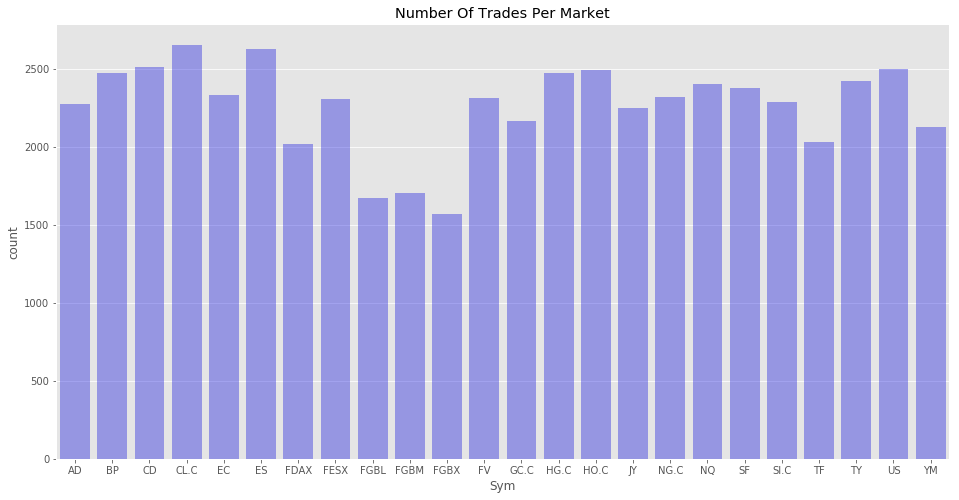

In [21]:
plt.figure(figsize=(16,8))
plt.title('Number Of Trades Per Market')
sns.countplot(all_data.Sym, color='blue',alpha = 0.4)
#plt.set_axis_bgcolor("lightslategray")
plt.show()

### ** Create sector dictionary and a column in <code style="color:steelblue"> all_data <code> that maps every symbol to corresponding sector**

In [22]:
def map_sector_to_symbol(symbol):
    
    sectors = {'EQUITY' : ['ES','YM','NQ','TF','FDAX','FESX'], 'INT_RATE' : ['FV','TY','US','FGBM','FGBL','FGBX=11INC'],
                'FX' : ['EC','BP','SF','JY','AD','CD'], 'CMDTY' : ['CL.C','NG.C','HO.C','GC.C','HG.C','SI.C']}
    
    for sector in sectors:
        for symbols in sectors[sector]:
            if symbol in symbols:
                return sector
    return None

In [23]:
all_data['Sector'] = all_data['Sym'].apply(map_sector_to_symbol)

In [24]:
all_data.head()

,Date,Long_Short,Win_Loss,PL,T1,PV1,PV2,PV3,PV4,PV5,...,PctD1,PctD2,PctD3,PctD4,PctD5,Sym,RollRet100,CumRet,RollingRet100_byPos,Sector
186,2004-03-31,Long,1,9504.0,525.0,0.082274,0.012197,0.032377,0.095653,0.221467,...,0.475936,0.823529,0.358289,0.566845,0.475936,AD,-0.070608,-0.003963,0.038370,FX
187,2004-04-06,Long,1,2688.0,560.0,0.154623,0.095890,0.025086,0.151027,0.266952,...,0.130631,-0.202703,-0.004505,-0.090090,-0.283784,AD,-0.060555,0.000789,0.043863,FX
188,2004-04-07,Long,1,13908.0,530.0,0.090398,0.020684,0.019918,0.062819,0.065245,...,0.129944,0.327684,0.395480,0.389831,-0.192090,AD,-0.043080,0.002133,0.037255,FX
193,2004-04-21,Long,0,-10296.0,570.0,0.102927,0.032548,0.001000,0.038074,0.025686,...,-0.311787,-0.501901,-0.163498,-0.673004,-0.596958,AD,-0.035806,0.018749,0.037255,FX
194,2004-04-22,Long,0,-8136.0,555.0,0.028976,0.093742,0.135684,0.223604,0.085274,...,-0.159836,-0.495902,-0.118852,-0.295082,-0.700820,AD,-0.048906,0.013601,0.034805,FX


## Now we're ready to start modeling and exploring features
<hr><br>
**1. First, we'll split the data into training and test sets. In this case, since we're dealing with a time ordered series, we'd like to train on old data and test on more recent observations.**
<br>

**2. Then, we'd like to use machine learning to identify the most promising features in our data set and so we'll train 4 classification algorithms that come with built-in feature selection. We'll also optimize our classifiers' hyperparameters using cross-validation.**

In [25]:
all_data.set_index('Date',inplace=True)

split_date = pd.datetime(2013,12,31)
train = all_data.loc[all_data.index<= split_date] 
test = all_data.loc[all_data.index> split_date]

In [27]:
X_train = train.drop(['Long_Short','Sym','PL','PctRet','Win_Loss', 'Sector'], axis=1)
y_train = train['Win_Loss']
 
X_test = test.drop(['Long_Short','Sym','PL','PctRet','Win_Loss', 'Sector'], axis=1)
y_test = test['Win_Loss']

### Build model pipelines

In [28]:
# Pipeline dictionary
pipeline_dict = {'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)), 
                                     'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
                                     'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
                                     'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
                                     
                }

In [29]:
# Logistic Regression hyperparameters
l1_hyperparameters = { 'logisticregression__C': [0.001,0.01,0.1]}
l2_hyperparameters = { 'logisticregression__C': [0.001,0.01,0.1]}

In [30]:
# Random Forest hyperparameters
rf_hyperparameters = { 'randomforestclassifier__n_estimators': [100, 200],
                         'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]}

In [31]:
gb_hyperparameters = {'gradientboostingclassifier__n_estimators': [100, 200], 
                    'gradientboostingclassifier__learning_rate': [0.05, 0.1], 
                     'gradientboostingclassifier__max_depth': [1, 3]}

In [32]:
# Create hyperparameters dictionary
hp_dict = { 'l1': l1_hyperparameters, 'l2': l2_hyperparameters, 'rf': rf_hyperparameters, 'gb': gb_hyperparameters}

#### Following step takes a few minutes

In [33]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipeline_dict.items(): 
    # Create cross-validation object from pipeline and hyperparameters, n_jobs=-1 uses all CPU cores
    model = GridSearchCV(pipeline, hp_dict[name], cv=5, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted')

l1 has been fitted
l2 has been fitted
rf has been fitted
gb has been fitted


In [34]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.546772068511199
l2 0.54762458343021
rf 0.5513963161021984
gb 0.5482704280658245


In [35]:
# Display best_params_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_params_)

l1 {'logisticregression__C': 0.01}
l2 {'logisticregression__C': 0.1}
rf {'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 200}
gb {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 100}


<hr>
### Next, we'll fit the same 4 models with the optimal hyperparameters, extract ranked feature importance from each to  see if there is consensus among our models on which are the most predictive features
<hr>

In [37]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,max_depth=3).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)

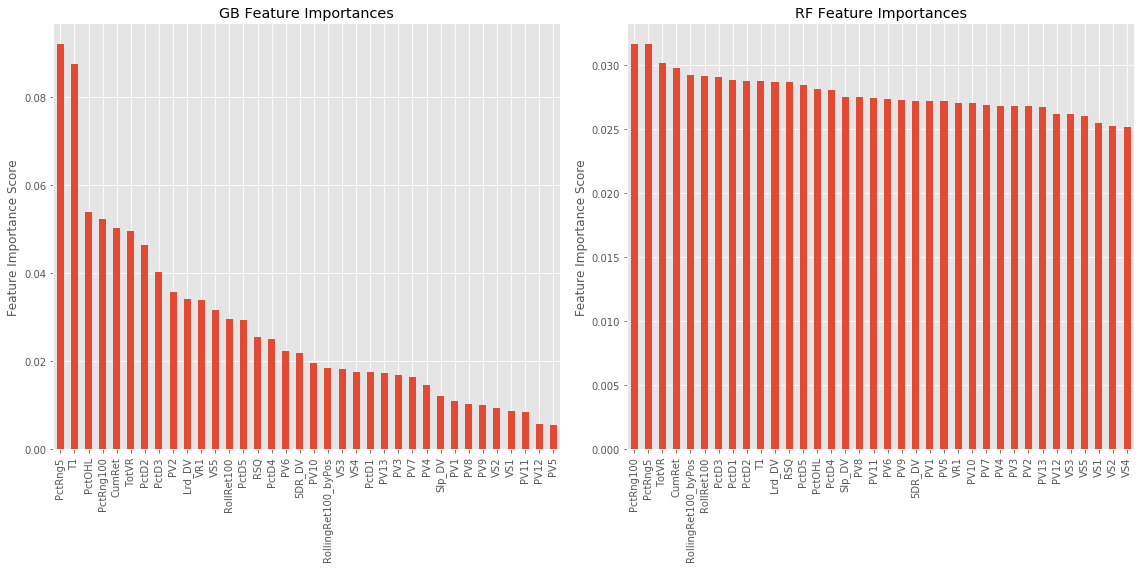

In [42]:
feat_imp_gb = pd.Series(gb.feature_importances_,X_train.columns).sort_values(ascending=False)
feat_imp_rf = pd.Series(rf.feature_importances_,X_train.columns).sort_values(ascending=False)

plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(1, 2, 1)
feat_imp_gb.plot(kind='bar', title='GB Feature Importances', figsize=(16,8))
plt.ylabel('Feature Importance Score')
plt.subplot(1, 2, 2)
feat_imp_rf.plot(kind='bar', title='RF Feature Importances', figsize=(16,8))
plt.ylabel('Feature Importance Score')
plt.tight_layout();

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lr_l1 = LogisticRegression(C=0.01, penalty='l1', dual=False).fit(X_train_scaled, y_train)
lr_l2 = LogisticRegression(C=0.1, penalty='l2', dual=False).fit(X_train_scaled, y_train)

model1 = SelectFromModel(lr_l1, prefit=True)
model2 = SelectFromModel(lr_l2, prefit=True)

feature1_idx = model1.get_support()
feature2_idx = model2.get_support()

feature1_name = X_train.columns[feature1_idx]
feature2_name = X_train.columns[feature2_idx]

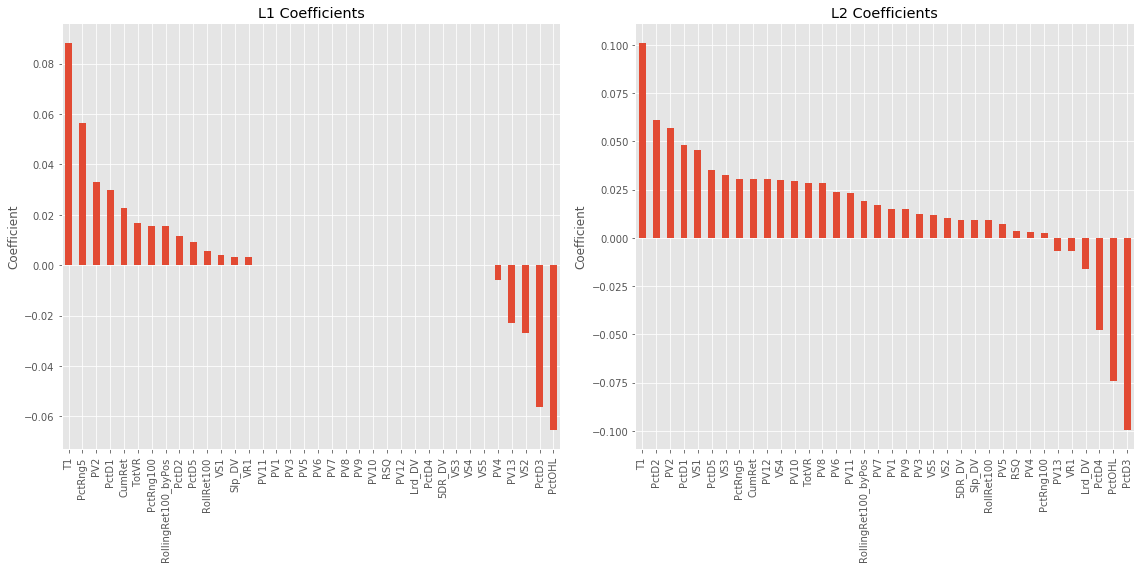

In [47]:
lr_l1_coef = lr_l1.coef_.flatten()
lr_l2_coef = lr_l2.coef_.flatten()

feat_imp_l1 = pd.Series(lr_l1_coef,X_train.columns).sort_values(ascending=False)
feat_imp_l2 = pd.Series(lr_l2_coef,X_train.columns).sort_values(ascending=False)

plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(1, 2, 1)
feat_imp_l1.plot(kind='bar', title='L1 Coefficients', figsize=(16,8))
plt.ylabel('Coefficient')
plt.subplot(1, 2, 2)
feat_imp_l2.plot(kind='bar', title='L2 Coefficients', figsize=(16,8))
plt.ylabel('Coefficient')
plt.tight_layout();

## Next steps:
 * Narrow down the list of features based on an intersection of all 4 models rankings
 * Discretize our features with equal number of observations in each bin
 * Plot each binned feature against our target variables - Win_Loss & PctRet to get a better sense of the nature of the relationships

In [48]:
reduced_feat = ['T1','PctRng5','PV2','PctD1','CumRet','TotVR','PctRng100','PctOHL','PctD3','VS2','PV13','VR1','Lrd_DV']
new_feat = train[reduced_feat]
new_feat.head()

,T1,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,PctD3,VS2,PV13,VR1,Lrd_DV
Date,,,,,,,,,,,,,
2004-03-31,525.0,0.566845,0.012197,0.475936,-0.003963,1.201205,1.218531,0.009434,0.358289,0.349497,0.096541,0.270306,194.5
2004-04-06,560.0,0.513514,0.095890,0.130631,0.000789,0.904435,1.278744,0.149123,-0.004505,0.443065,0.008476,0.565409,150.4
2004-04-07,530.0,0.412429,0.020684,0.129944,0.002133,0.659084,0.811833,0.589041,0.395480,0.147982,0.202630,0.750645,257.0
2004-04-21,570.0,0.425856,0.032548,-0.311787,0.018749,1.225677,1.179071,0.455357,-0.163498,0.064760,0.044511,2.091955,838.2
2004-04-22,555.0,0.418033,0.093742,-0.159836,0.013601,1.142937,1.068175,0.647059,-0.118852,0.444562,0.013363,0.276042,361.5


In [49]:
binned_feat = new_feat.apply(lambda x: pd.qcut(x,8,labels=list(range(8)),duplicates='drop'),axis=0)

In [50]:
binned_feat[['Sector','Sym','Win_Loss','PctRet']] = train[['Sector','Sym','Win_Loss','PctRet']]
binned_feat.head()

,T1,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,PctD3,VS2,PV13,VR1,Lrd_DV,Sector,Sym,Win_Loss,PctRet
Date,,,,,,,,,,,,,,,,,
2004-03-31,2,5,0,7,2,4,5,0,6,6,6,1,1,FX,AD,1,0.004752
2004-04-06,3,4,5,3,2,1,6,3,2,7,1,3,1,FX,AD,1,0.001344
2004-04-07,2,0,0,3,2,0,2,7,6,1,7,5,2,FX,AD,1,0.006954
2004-04-21,3,1,1,0,2,4,5,6,0,0,5,7,6,FX,AD,0,-0.005148
2004-04-22,3,1,4,1,2,3,4,7,1,7,2,1,3,FX,AD,0,-0.004068


In [52]:
# helper function to plot feature distribution vs win_loss rate and feature vs avg(PctRet) side by side
def winRate_avgProfit_plots(segment_by):
    fig,(ax1, ax2) = plt.subplots(ncols=2,sharey=False,sharex=True,figsize=(20,6))

    binned_feat.mean_win_rate = binned_feat.PctRet.mean()

    ax1.set_ylim([0.41,0.53])
    sns.barplot(x=segment_by,data=binned_feat,y='Win_Loss',color='green', ax=ax1,alpha=0.6)

    sns.barplot(x=segment_by,data=binned_feat,y='PctRet', ax=ax2,color='green',alpha=0.6)

    plt.suptitle('Performance By {}'.format(segment_by))

    plt.show()

#### Right away we encounter unusual behaviour by one of our selected features:
T1 appears to have an obvious linear ralationship with Win_Loss but not with PctRet. And since we're using Win_Loss as the class label, including T1 has the potential to inflate classification performance without adding to returns. We'll flag T1 and remove it from our list.

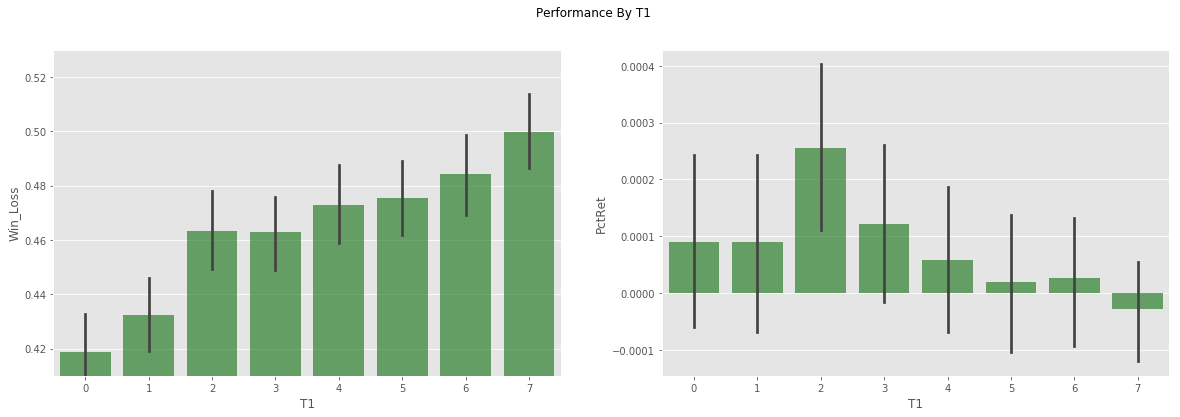

In [53]:
winRate_avgProfit_plots('T1')

#### The next 2 features are much better behaved:
Strong linear relationship with both average win rate and average percent return per trade

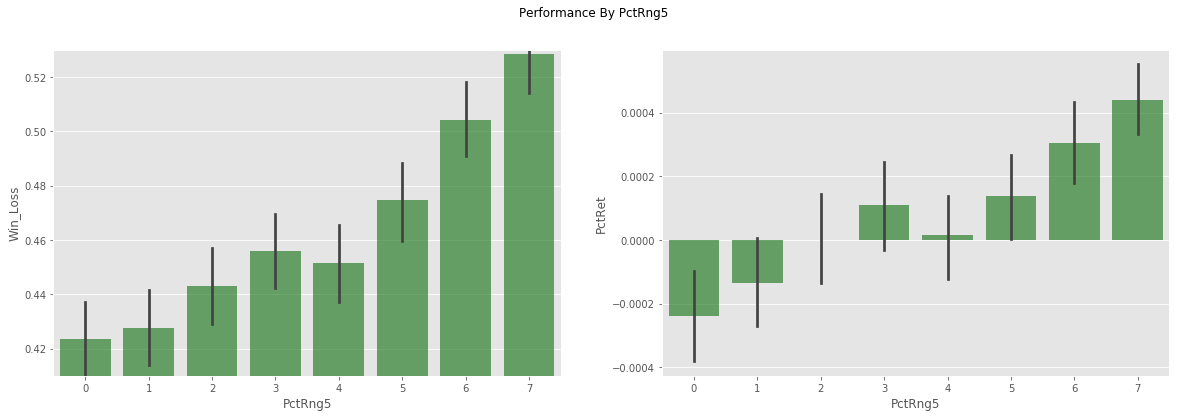

In [54]:
winRate_avgProfit_plots('PctRng5')

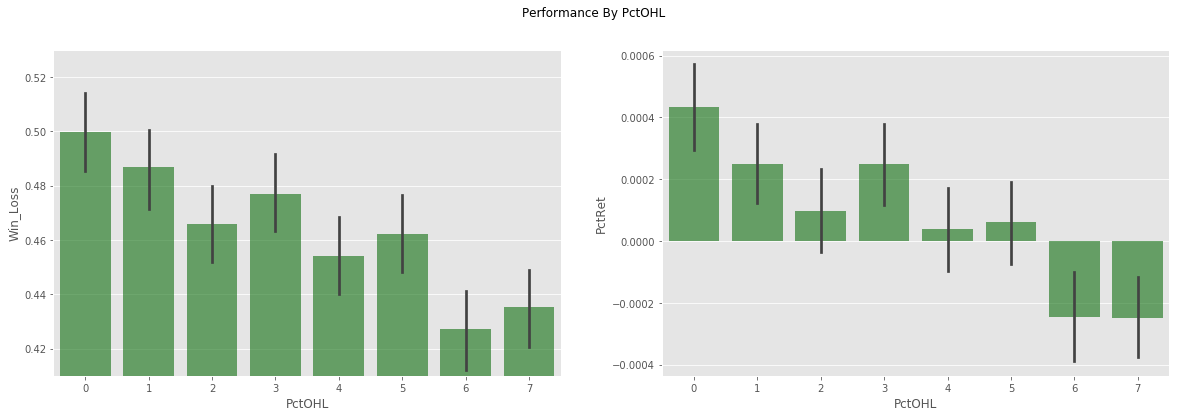

In [55]:
winRate_avgProfit_plots('PctOHL')

#### PctD3 exhibits nonlinear behaviour with respect to our target variable and bears further observation

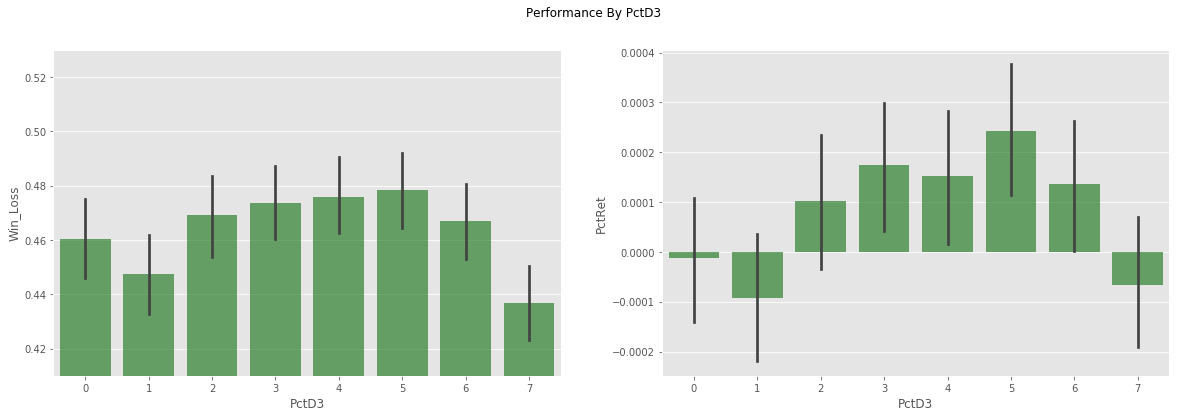

In [69]:
winRate_avgProfit_plots('PctD3')

#### The rest of the features appear linear or near linear

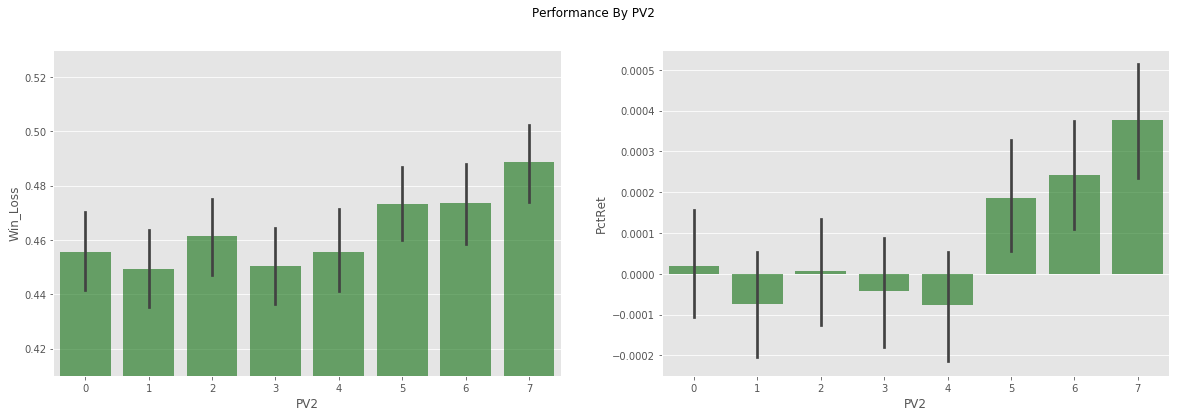

In [56]:
winRate_avgProfit_plots('PV2')

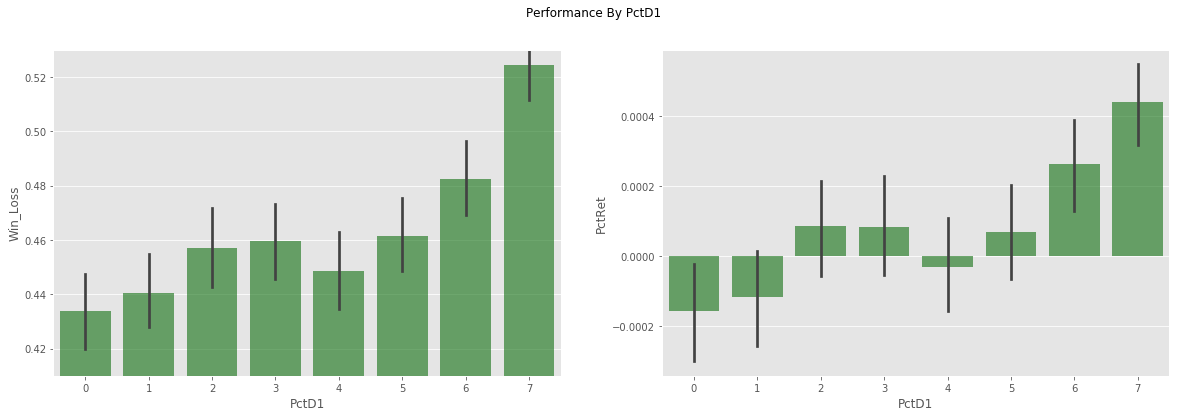

In [57]:
winRate_avgProfit_plots('PctD1')

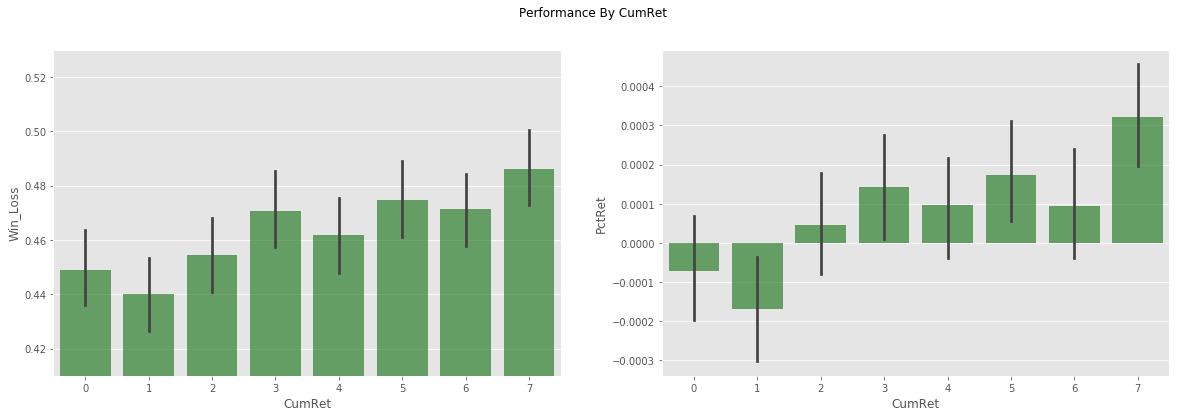

In [58]:
winRate_avgProfit_plots('CumRet')

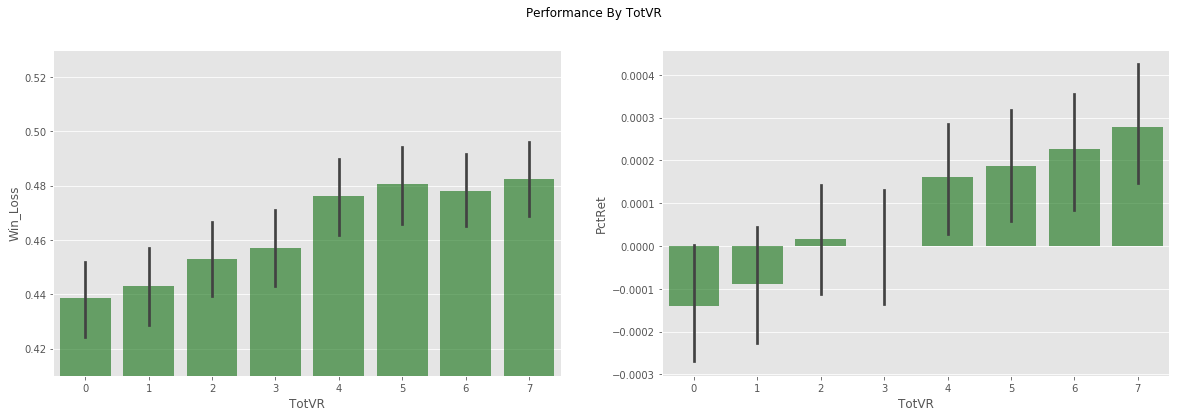

In [59]:
winRate_avgProfit_plots('TotVR')

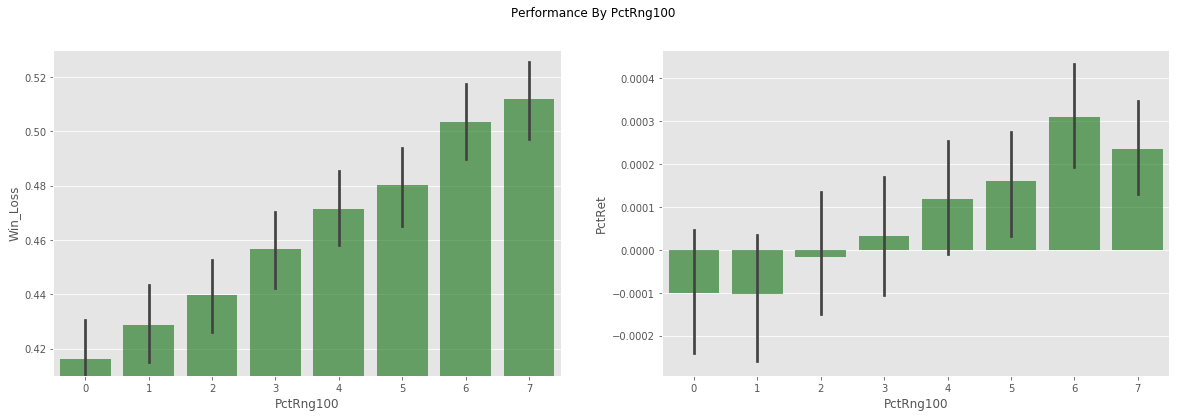

In [60]:
winRate_avgProfit_plots('PctRng100')

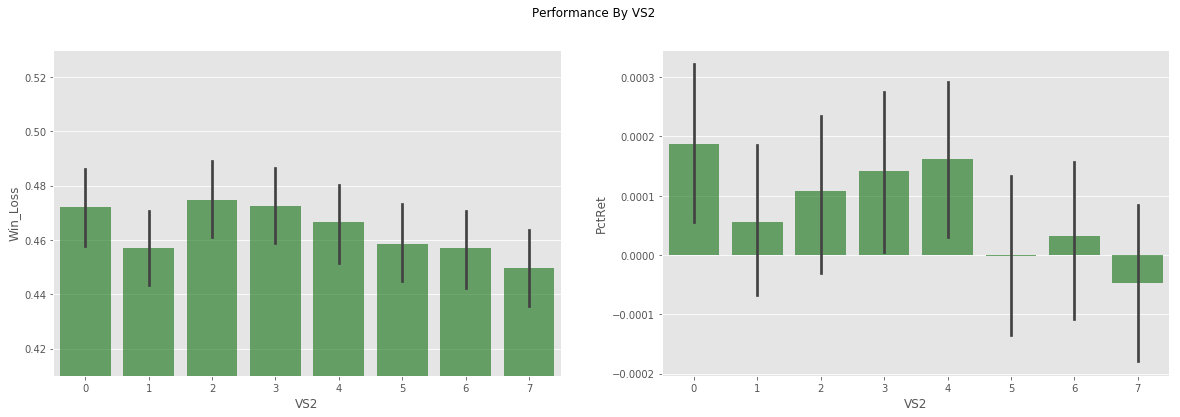

In [62]:
winRate_avgProfit_plots('VS2')

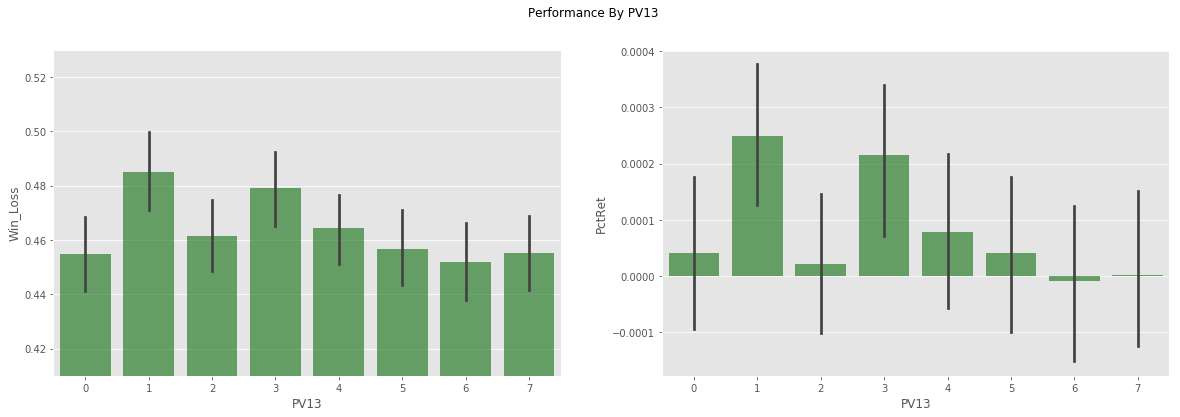

In [63]:
winRate_avgProfit_plots('PV13')

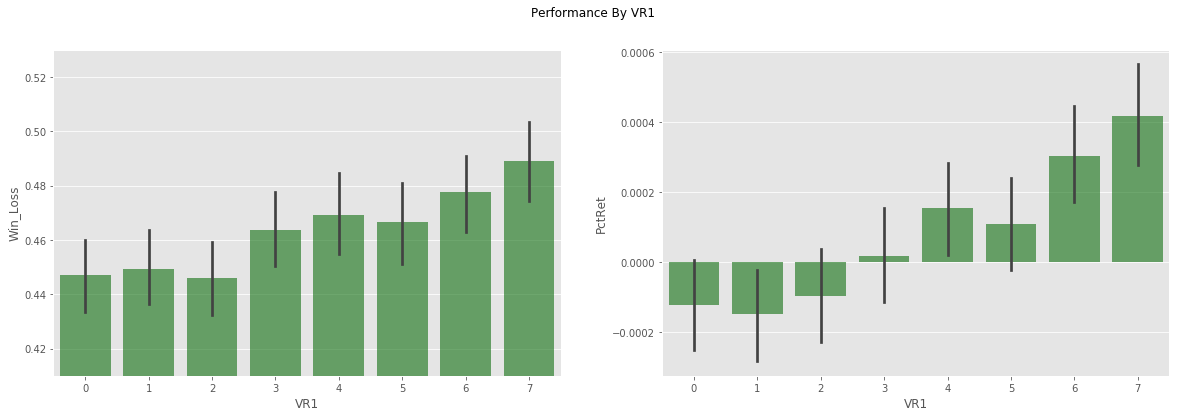

In [64]:
winRate_avgProfit_plots('VR1')

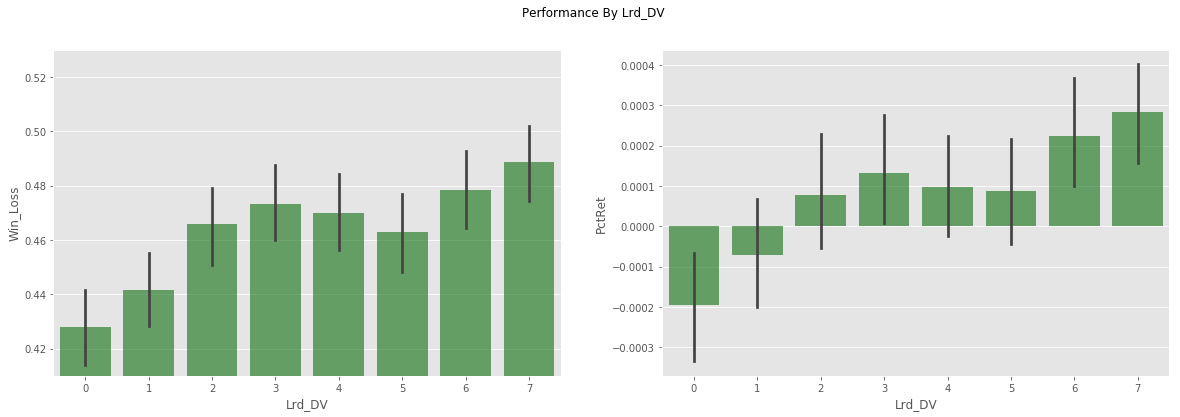

In [65]:
winRate_avgProfit_plots('Lrd_DV')

#### Even though we don't plan on using sector as a feature, we'd like to see how performance varies by sector

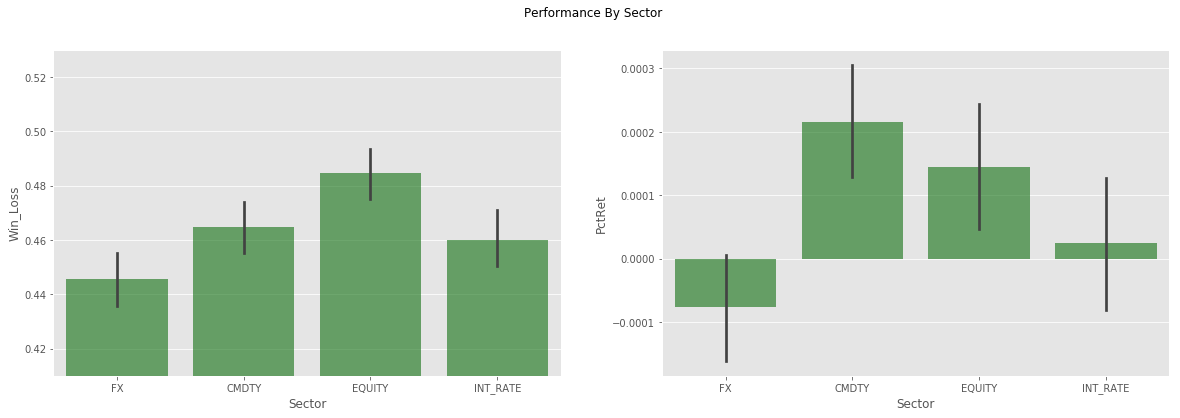

In [67]:
winRate_avgProfit_plots('Sector')

### Remove T1 and save as <code style="color:steelblue"> reduced_dim.csv <code> 

In [68]:
#Remove T1 feature
binned_feat.drop(['T1'],axis=1,inplace=True)
cols = binned_feat.columns
reduced_dim = all_data[cols]
reduced_dim['Date'] = all_data.index.values

# Save Reduced Dimensions table
reduced_dim.to_csv('reduced_dim.csv', index=None)